In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import glob

# webscraping
import json
import urllib
from bs4 import BeautifulSoup
from urllib.request import urlopen
import os

# plotting/mapmaknig
import geopandas as gpd
from geospatial_functions import get_background_map
import rasterio
from rasterio.plot import show as rioshow
# import folium

In [2]:
path = os.getcwd()
home_path = os.path.dirname(path)
data_folder = f'{home_path}\\Data'
gis_folder = f'{home_path}\\GIS'

In [3]:
files = glob.glob(f"{data_folder}\\*.txt")
files

['C:\\Users\\david\\Documents\\@@ Python\\Jaar 5\\Q3\\ENVM1502\\Git\\ENVM1502-Catchment-model\\Data\\120_days_01310521.txt',
 'C:\\Users\\david\\Documents\\@@ Python\\Jaar 5\\Q3\\ENVM1502\\Git\\ENVM1502-Catchment-model\\Data\\2007-2010_01310521.txt',
 'C:\\Users\\david\\Documents\\@@ Python\\Jaar 5\\Q3\\ENVM1502\\Git\\ENVM1502-Catchment-model\\Data\\station_ids.txt',
 'C:\\Users\\david\\Documents\\@@ Python\\Jaar 5\\Q3\\ENVM1502\\Git\\ENVM1502-Catchment-model\\Data\\station_ids_with_Q.txt']

### station information:
station generated by considering all station in the same hydraulic unit, ids from search on USGS site

In [4]:
ids = np.loadtxt(f'{data_folder}\\station_ids.txt',dtype=int)

In [5]:
ids

array([131199050,   1312000,   1315000,   1315170,   1315226,   1315227,
         1315500,   1318500,   1327500,   1327750,   1328770,   1329490,
         1329500,   1330000,   1330500,   1334500,   1335754,   1335755,
         1358000,   1359133,   1359135,   1359528,   1359750,   1360640,
         1361000,   1361200,   1362090,   1362192, 136219503,  13621955,
         1362200,   1362230,   1362297, 136230002,   1362322,   1362336,
         1362342,   1362357,   1362368,   1362370,   1362380,   1362465,
         1362487,   1362497,   1362500,   1363382,   1363556,   1364500,
         1372051,   1372500, 137449480,   1374505,   1374531,   1374559,
         1374581,   1374598, 137462010,   1374654,   1374701,   1374781,
         1374821,   1374890,   1374901,   1374918,   1374930,   1374941,
         1374976,   1374987, 137499350,   1375000])

In [60]:
begin_end_date_csv = f"{data_folder}\\Q_ids_with_begin-end-date.csv"
if os.path.exists(begin_end_date_csv):
    df_id_dates = pd.read_csv(begin_end_date_csv,index_col=0)
    df_id_dates.set_index("ID",inplace=True)
else:
    lst_begin_date  = []
    lst_end_date    = []
    lst_no_flow     = []
    lst_description = []
    for i in ids:
        print(i,end="\r")
        url_start_table = "https://waterdata.usgs.gov/nwis/inventory/?site_no="
        end = "&agency_cd=USGS"
        site = url_start_table + f'0{i}' + end
        page = urlopen(site)
        html_bytes = page.read()
        html = html_bytes.decode("utf-8")
        table = html[html.find('<div id="stationTable">'):html.find("</table>")]
        table_data = [[cell.text.strip() for cell in row("td")]
                                 for row in BeautifulSoup(table)("tr")][2:]
        headers = [[cell.text.strip() for cell in row("th")]
                              for row in BeautifulSoup(table)("tr")][0]
        df_station = pd.DataFrame(data=table_data, columns=headers)
        try:
            series_begin_date = df_station.set_index("Data Type").loc["Discharge, cubic feet per second","Begin Date"]
            series_end_date   = df_station.set_index("Data Type").loc["Discharge, cubic feet per second","End Date"]
            description       = '; '.join([cell.text.strip().replace(u'\xa0', u'') for cell in BeautifulSoup(table)("dd")][:3])
            if type(series_begin_date) == str:
                begin_date = series_begin_date
                end_date   = series_end_date
            else:
                begin_date = series_begin_date.iloc[0]
                end_date = series_end_date.iloc[0]

            lst_begin_date.append(begin_date)
            lst_end_date.append(end_date)
            lst_description.append(description)
        except KeyError:
            lst_no_flow.append(i)
    
    df_id_dates = pd.DataFrame(data=list(zip(ids,lst_begin_date,lst_end_date,lst_description)), columns=["ID","Begin Date","End Date","Description"])
    df_id_dates["Area_temp"] = df_id_dates.apply(lambda x: x.Description[x.Description.find("Drainage area")+15:x.Description.find("square miles")-1], axis=1)
    df_id_dates["Area_m2"]   = df_id_dates.apply(lambda x: float(x.Area_temp.replace(u",","")) * 2.59e+6    
                                                    if (x.Area_temp[0].isnumeric() and len(x.Area_temp) < 6)
                                                    else -999, axis=1)
    df_id_dates.drop(columns=["Area_temp"], inplace=True)
    df_id_dates.to_csv(begin_end_date_csv)

In [61]:
len(df_id_dates[df_id_dates.Area_m2>-999])

66

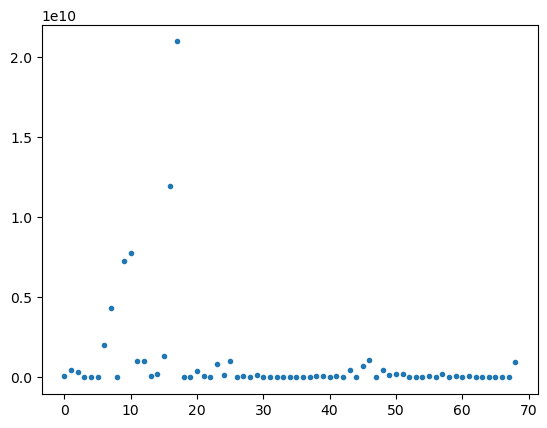

In [77]:
plt.plot(df_id_dates["Area_m2"].values,marker=".",lw=0)

In [78]:
df_id_dates.Area_m2.argmax()

17

In [79]:
df_id_dates.iloc[[17]]

,Begin Date,End Date,Description,Area_m2
ID,,,,
1335755,1946-02-21,2023-03-26,"Latitude 42°45'08"", Longitude 73°41'20"" NA...",2.095310e+10


In [7]:
len("Drainage area")

13

#### Hourly: 

too specific

In [8]:
url_start = "https://waterservices.usgs.gov/nwis/iv/?sites="
pram = "&parameterCd=00060"
start = "&startDT="
t0 = "2023-03-15T05:45:18.716-04:00"
end_time = "&endDT="
tend = "2023-03-22T05:45:18.716-04:00"
post_fix = "&siteStatus=all&format=rdb"

# Daily

Webscrape the USGS data

In [9]:
url_start_daily = "https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no="
begin_date = "&legacy=&referred_module=sw&period=&begin_date="
end_data = "&end_date="

In [64]:
lst_data   = []
lst_errors = []
found_ids  = []

if len(glob.glob(f"{data_folder}\\Q\\*.csv")) > 20:
    for path in glob.glob(f"{data_folder}\\Q\\*.csv"):
        df = pd.read_csv(path)
        # check columns integrity, else this will fail
        df = df[['agency_cd', 'site_no', 'datetime', 'Data codes', 'Q_m3_s_mean']]
        df.set_index("datetime",inplace=True, drop=True,append=False)
        df = df[df["Q_m3_s_mean"]>-999]
        site_no = df['site_no'].iloc[0]
        found_ids.append(site_no)
        area = df_id_dates.loc[site_no,"Area_m2"]
        df["Q_mm_d"]  = df["Q_m3_s_mean"]  * 86400 / area * 1000  # s -> d, m3 -> mm
        lst_data.append(df)
else:
    for i in df_id_dates.index:
        condition = True
        # condition = i == 69
        if condition: # mainly for debugging 
            site = url_start_daily + f'0{df_id_dates.loc[i,"ID"]}' + begin_date + df_id_dates.loc[i,"Begin Date"] \
                                                                   + end_data + df_id_dates.loc[i,"End Date"]
            print(i,end="\r")
            page = urlopen(site)
            html_bytes = page.read()
            html = html_bytes.decode("utf-8")
            if html[:19] == "No sites/data found":
                lst_errors.append([i,df_id_dates.loc[i,"ID"]])
                pass
            elif len(html) < 1700:
                lst_errors.append([i,df_id_dates.loc[i,"ID"]])
                pass
            else:
                data = html[html.find("\n# \n")+4:].split('\n')
                header = data[0].split("\t")
                if header[0] == "agency_cd":
                    header = ['agency_cd', 'site_no', 'datetime', 'Q_ft3_s_mean',
                       'Data codes']
                else: 
                    print(i, header)
                rows = data[2:]
                df = pd.DataFrame(data=[row.split('\t') for row in rows],columns=header)
                df.replace({"":pd.NA},inplace=True)
                df.dropna(inplace=True)
                df["Q_m3_s_mean"] = df.apply(lambda x: float(x['Q_ft3_s_mean']) * 0.0283168466\
                                             if x['Q_ft3_s_mean'][0].isnumeric()
                                             else -999, axis=1)
                df_out = df[['agency_cd', 'site_no', 'datetime', 'Data codes', 'Q_m3_s_mean']]
                lst_data.append(df_out)
    # post processing
    if len(lst_errors) > 0:
        arr_errors = np.array(lst_errors)
        found_ids = list(set(df_id_dates.ID.values).difference(set(arr_errors[:,1])))
    else:
        found_ids = df_id_dates.ID.values
    
    for df in lst_data:
        df.to_csv(f'{data_folder}\\Q\\{df.iloc[0]["site_no"]}.csv')
    
    # save to access later
    np.savetxt(f"{data_folder}\\station_ids_with_Q.txt",np.array(found_ids))

The 63 stations with data in the given time are store in lst_data

In [65]:
len(lst_data)

63

which can be plotted:

In [80]:
wanted_index = list(ids).index(1335755)
wanted_index

17

#### loading geopackages to make map

In [81]:
gdf_station       = gpd.read_file(f"{gis_folder}\\discharge_stations_with_Q.gpk",driver="GPKG",crs="EPSG:4326")   
# fixing indexing
gdf_station.index = gdf_station.apply(lambda x: int(x.site_no[1:]),axis=1)
gdf_station       = gdf_station.drop(columns=["site_no"])

outline           = gpd.read_file(f"{gis_folder}\\hudson_basin.SHP",driver="SHP",crs="EPSG:26918")
main_rivers       = gpd.read_file(f"{gis_folder}\\main_rivers_hudson_basin.gpkg",driver="GPKG",crs="EPSG:26918")   
all_rivers        = gpd.read_file(f"{gis_folder}\\rivers_hudson_basin.gpkg",driver="GPKG",crs="EPSG:26918")   

# fixing crs
for layer in [outline,main_rivers,all_rivers]:
    layer.geometry = layer.geometry.to_crs("EPSG:4326")

In [82]:
def plot_map(ax, station_id):
    legend_field = []

    # stations
    gdf_station.plot(ax=ax, markersize=2, color="C1")
    legend_field.append(mpl.lines.Line2D([],[],color='C1',linewidth=0,marker=".",label='station'))

    outline.plot(ax=ax, edgecolor="C3", facecolor="None")
    main_rivers.plot(ax=ax, color="lightskyblue",alpha=0.6,zorder=-1,lw=1.5)
    all_rivers.plot(ax=ax, color="lightskyblue",alpha=0.2,zorder=-2,lw=0.4)

    bounds_stations = (ax.get_xlim()[0], ax.get_ylim()[0], ax.get_xlim()[1], ax.get_ylim()[1])

    # add background
    with rasterio.open(get_background_map("outline", bounds_stations)) as r:
        rioshow(r, ax=ax,zorder=-10)
    
    # remove lat/lon markers
    ax.set_xticks([])
    ax.set_yticks([])
    
    # zoom on one station
    given_station = gdf_station.loc[[station_id]]
    given_station.plot(ax=ax, color="C0",markersize=20)
    x, y = given_station.geometry.x.iloc[0], given_station.geometry.y.iloc[0]
    n = 1
    ax.set_xlim(x- n,x + n)
    ax.set_ylim(y -(2*n/3),y + (2*n/3))


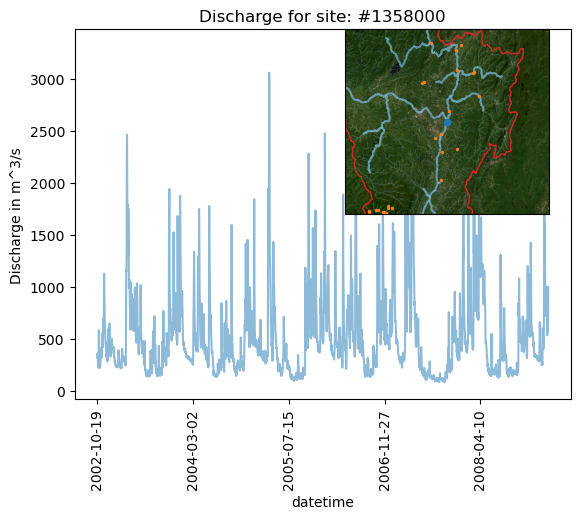

In [83]:
i = lst_data[wanted_index]
fig, ax = plt.subplots(1)
ax2 = ax.inset_axes([0.5,0.5, 0.5,0.5])
plot_map(ax2, i["site_no"].iloc[0])
i[['Q_m3_s_mean']].plot(ax=ax, alpha=0.5) #lw=0, marker=".",markersize=0.5
ax.set_title(f'Discharge for site: #{i["site_no"].iloc[0]}')
ax.legend().remove()
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_ylabel("Discharge in m^3/s");

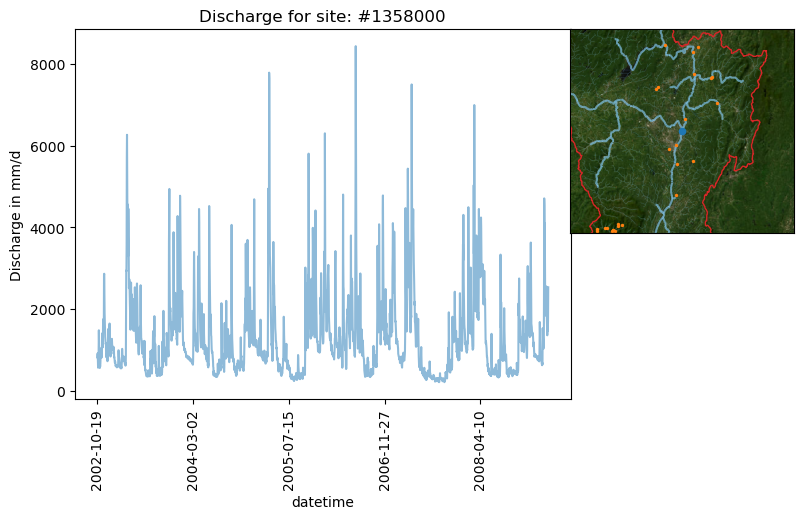

In [91]:
i = lst_data[wanted_index]
fig, ax = plt.subplots(1)
ax2 = ax.inset_axes([.95,0.45, 0.55,0.55])
plot_map(ax2, i["site_no"].iloc[0])
i[['Q_mm_d']].plot(ax=ax, alpha=0.5) #lw=0, marker=".",markersize=0.5
ax.set_title(f'Discharge for site: #{i["site_no"].iloc[0]}')
ax.legend().remove()
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_ylabel("Discharge in mm/d");